In [1]:
import random

import matplotlib.pyplot as plt
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate, VerticalFlip, Crop, PixelDropout, CropAndPad, RandomBrightnessContrast
)
import config
import paths
import randomness
from cnn_builder import *
from config import *
from dataset_functions import *
from functools import partial
from hypercube_set import HypercubeSet
from hypercube_loader import *
import numpy as np
import random
import randomness
import rendering
import training_history

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
os.chdir(os.getcwd().split("jupyter")[0])

inf = 2e32

%load_ext autoreload
%autoreload 2
%pylab inline

read_json_config(paths.config_file, network_type=None)

In [ ]:
font_mapping = {'family': 'Palatino Linotype', 'weight': 'normal', 'size': 11}
plt.rc('font', **font_mapping)

In [2]:
hc_array_red, max_class_idx, _ = load_hypercubes(plot_hc=False, plot_mask=False, n_max_cubes=inf, folder='media/Mateus_2022/red/')
hc_array_white, max_class_idx, _ = load_hypercubes(plot_hc=False, plot_mask=False, n_max_cubes=inf, folder='media/Mateus_2022/white/', baseline_class_idx=max_class_idx)
hc_array = hc_array_red + hc_array_white
hc_set = HypercubeSet(hc_array)
hc_set.identify_ground_samples()

Reading media/Mateus_2022/Area01\raw_112_rf.hdr ...
Reading media/Mateus_2022/Area01\raw_1984_rf.hdr ...
Reading media/Mateus_2022/Area01\raw_3904_rf.hdr ...
Reading media/Mateus_2022/Area01\raw_5744_rf.hdr ...
Reading media/Mateus_2022/Area01\raw_7584_rf.hdr ...
Min: 0.006377667188644409, Max: 0.16416394710540771, Size: (1840, 3200, 223)


In [ ]:
network_type = 'allopezr_2d'
read_json_config(paths.config_file, network_type=network_type)
network_name = get_name(network_type)

read_json_config(paths.config_file, network_type=network_type)

hc_set.split_hypercubes(test_percentage=test_split)

In [ ]:
X_train_original, y_train = hc_set.split(patch_size=config.patch_size, patch_overlap=config.patch_overlapping, train=True, start_percentage=.0, end_percentage=.01)

In [ ]:
hc_set.standardize()

In [ ]:
X_train_transformed, _ = hc_set.split(patch_size=config.patch_size, patch_overlap=config.patch_overlapping, train=True, start_percentage=.0, end_percentage=.01)

<Figure size 1300x800 with 0 Axes>

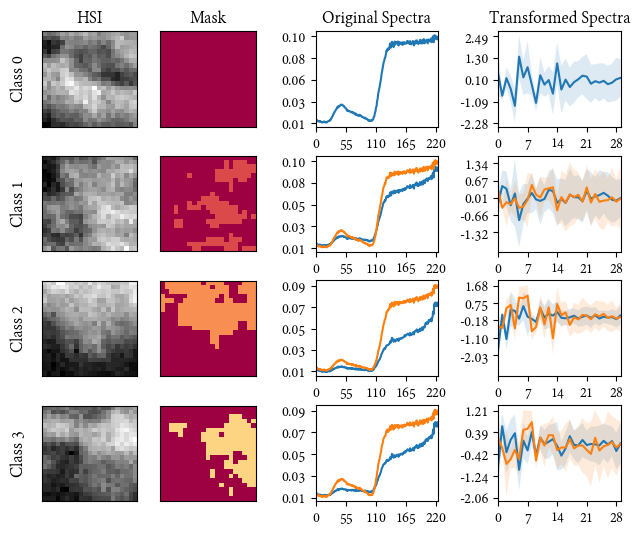

In [11]:
render_patches_examples(original_patches=X_train_original, standard_patches=X_train_transformed, labels=y_train_01, reduced_labels=y_train, target_labels=[0, 1, 2, 3])

In [ ]:
X_train_augment, y_train_augmented = augment_chunks(X_train_01, y_train_01)

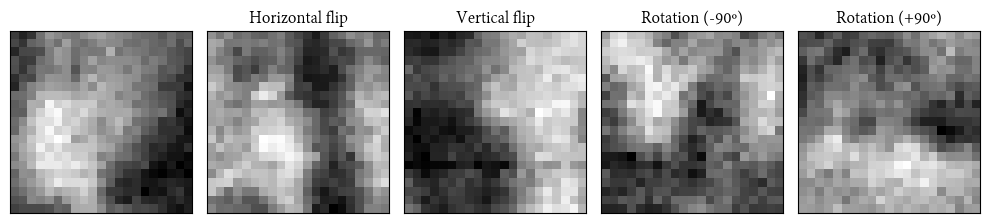

In [34]:
patch_idx = np.random.randint(len(X_train_01))
while y_train_01_reduced[patch_idx] == 0:
    patch_idx = np.random.randint(len(X_train_01))

rendering.render_patch_augmentation(X_train_augment[patch_idx * 5:patch_idx * 5 + 5])

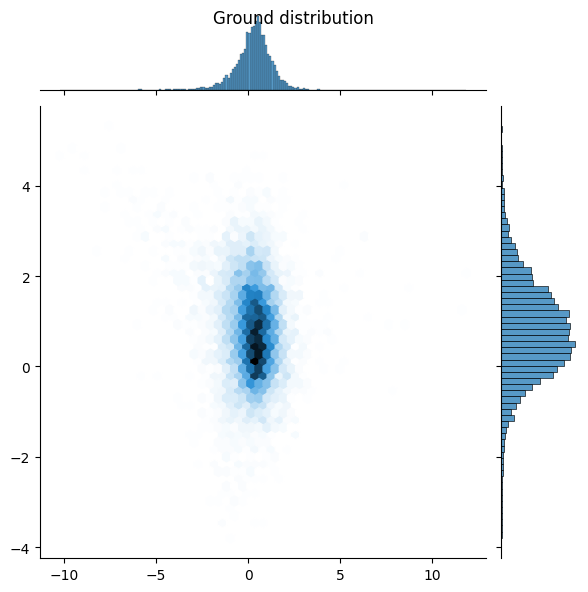

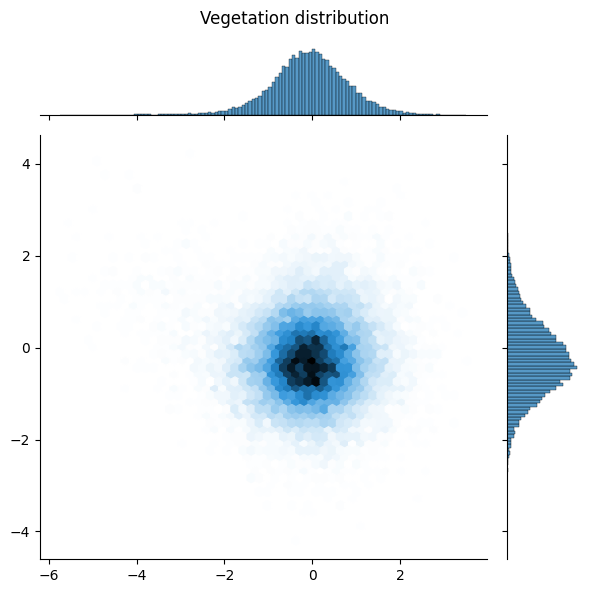

<Figure size 640x480 with 0 Axes>

In [134]:
X_train_flatten = get_center(X_train_02)
rendering.render_label_distribution(X_train_flatten, y_train_02_reduced)

## Load predicted swaths

In [83]:
variety = "red"
relative_path = "results/" + variety + "/swaths/"

# Find files with name such as "red_predicted_0.png" under relative path
# swaths = []
# for file in os.listdir(relative_path):
#     if file.endswith(".png") and file.startswith(variety + "_predicted_"):
#         swaths.append(file)

import re
pattern = re.compile("red_[0-9].png")
swaths = []
for file in os.listdir(relative_path):
    if pattern.match(file):
        swaths.append(file)

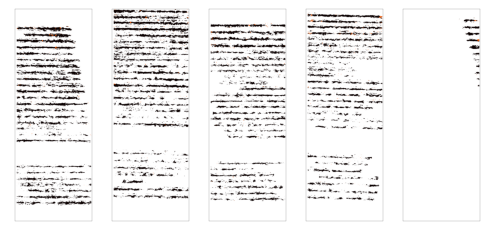

In [89]:
num_rows = 1
num_cols = len(swaths) // num_rows

# Change with of matplotlib border
plt.rcParams['axes.linewidth'] = 0.1

f = plt.figure(figsize=(num_cols, num_rows * 2.5))
for i, swath in enumerate(swaths):
    plt.subplot(num_rows, len(swaths), 1 + i)
    #plt.axis('off')
    # Turn off x-axis
    plt.gca().axes.get_xaxis().set_visible(False)
    # Turn off y-axis
    plt.gca().axes.get_yaxis().set_visible(False)

    # Read image with OpenCV
    opencv_image = cv2.imread(relative_path + swath, cv2.IMREAD_UNCHANGED)
    # Convert color from BGR to RGB
    opencv_image = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2RGB)

    if i % 2 == 1:
        # Flip vertically
        opencv_image = cv2.flip(opencv_image, 0)

    # Crop opencv_image
    opencv_image = opencv_image[100:2300, 1200:2000]

    plt.imshow(opencv_image)

# Reduce grid bottom margin
plt.subplots_adjust(bottom=0.01, top=0.99, left=0.1, right=0.9, wspace=0, hspace=0)
plt.tight_layout()
plt.savefig("results/" + variety + "/swath_grid.png", dpi=1000, transparent=True)
plt.show()

# # Read back the saved image with OpenCV
# opencv_image = cv2.imread("results/" + variety + "/swath_grid.png", cv2.IMREAD_COLOR)
# # Make a True/False mask of pixels whose BGR values sum to more than zero
# alpha = np.sum(opencv_image, axis=-1) > 100
# # Convert True/False to 0/255 and change type to "uint8" to match "na"
# alpha = np.uint8(alpha * 255)
# # Stack new alpha layer with existing image to go from BGR to BGRA, i.e. 3 channels to 4 channels
# opencv_image = np.dstack((opencv_image, alpha))
#
# # Save back to disk
# cv2.imwrite("results/" + variety + "/swath_grid.png", opencv_image)